In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings


plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (16,8)
plt.rc('font', family='Malgun Gothic')
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터

In [2]:
total= pd.read_csv("C:/Users/keogu/Desktop/IGPS/Data/서울시_데이터종합_수정_LUM.csv")

In [3]:
total.set_index(['대여소번호'], inplace=True)

# 회귀분석 - 수정전

## 스케일링

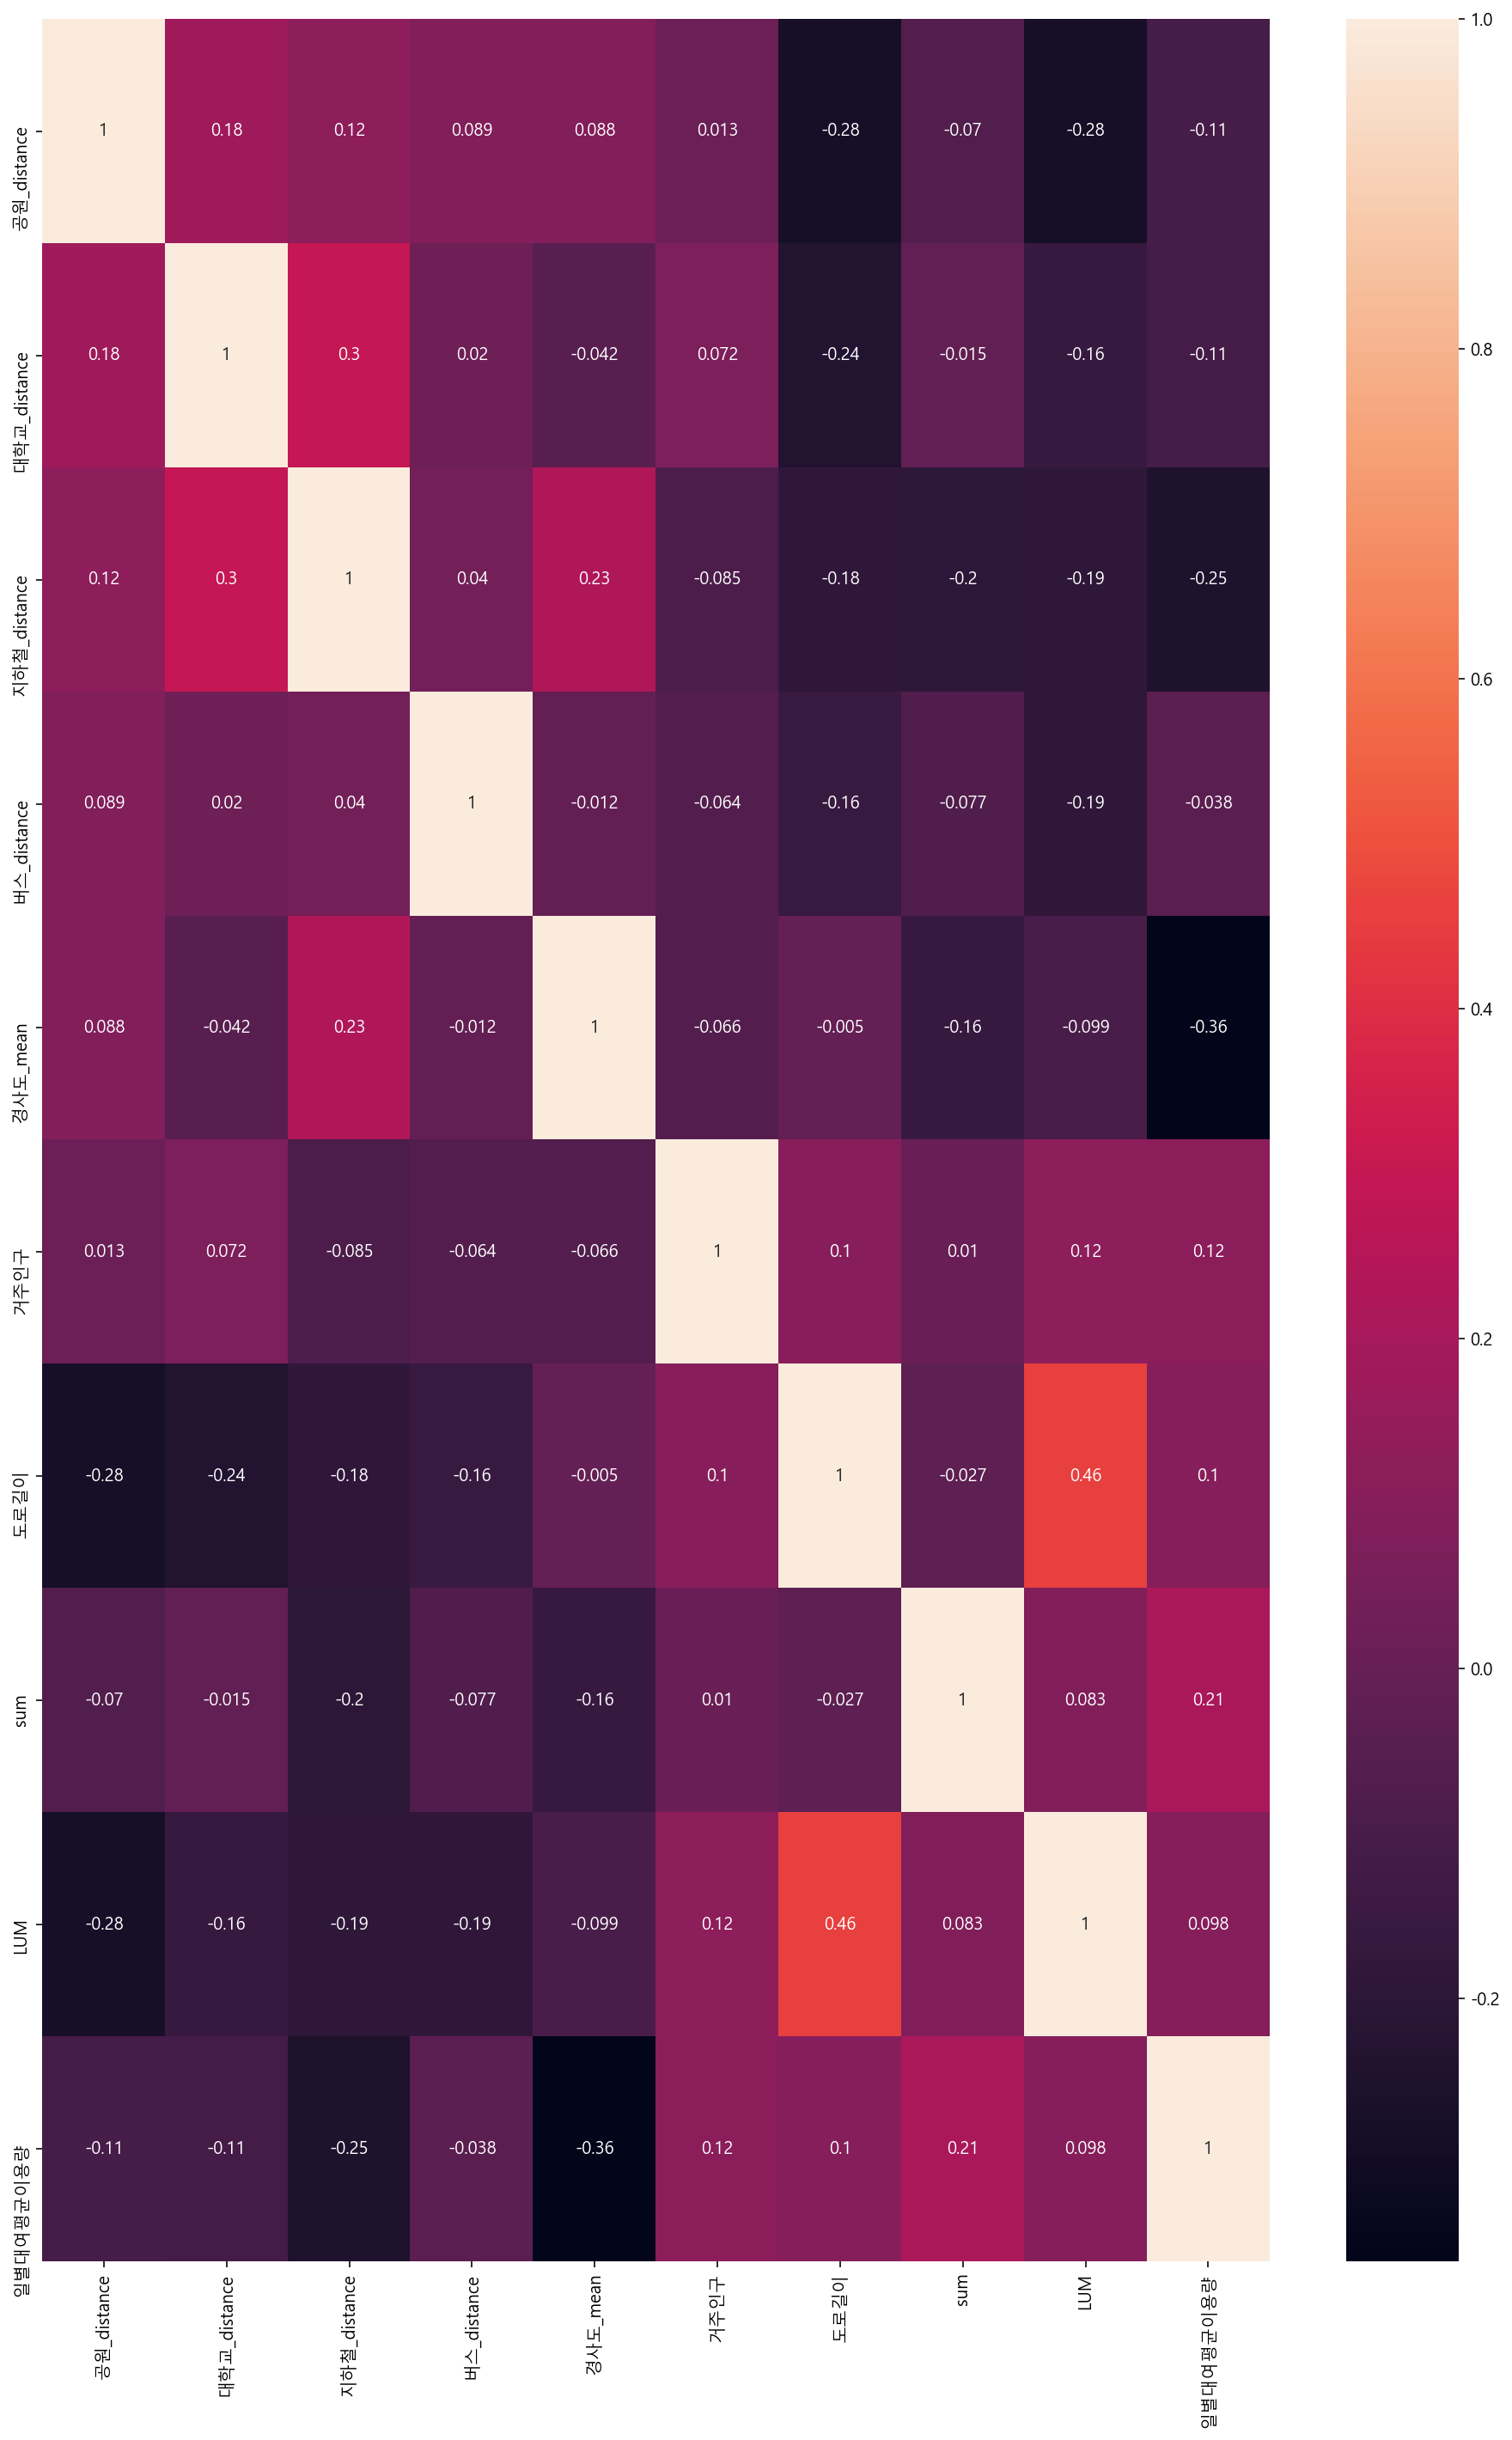

In [4]:
plt.figure(figsize=(16,24))
sns.heatmap(total.corr(), annot=True)

In [5]:
# 다중공선성 확인
from patsy import dmatrix, dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('일별대여평균이용량 ~  공원_distance + 대학교_distance + 지하철_distance + 버스_distance + 경사도_mean + 거주인구 + 도로길이 + sum + LUM', data=total, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,22.9,Intercept
1,1.1,공원_distance
2,1.2,대학교_distance
3,1.2,지하철_distance
4,1.1,버스_distance
5,1.1,경사도_mean
6,1.0,거주인구
7,1.4,도로길이
8,1.1,sum
9,1.4,LUM


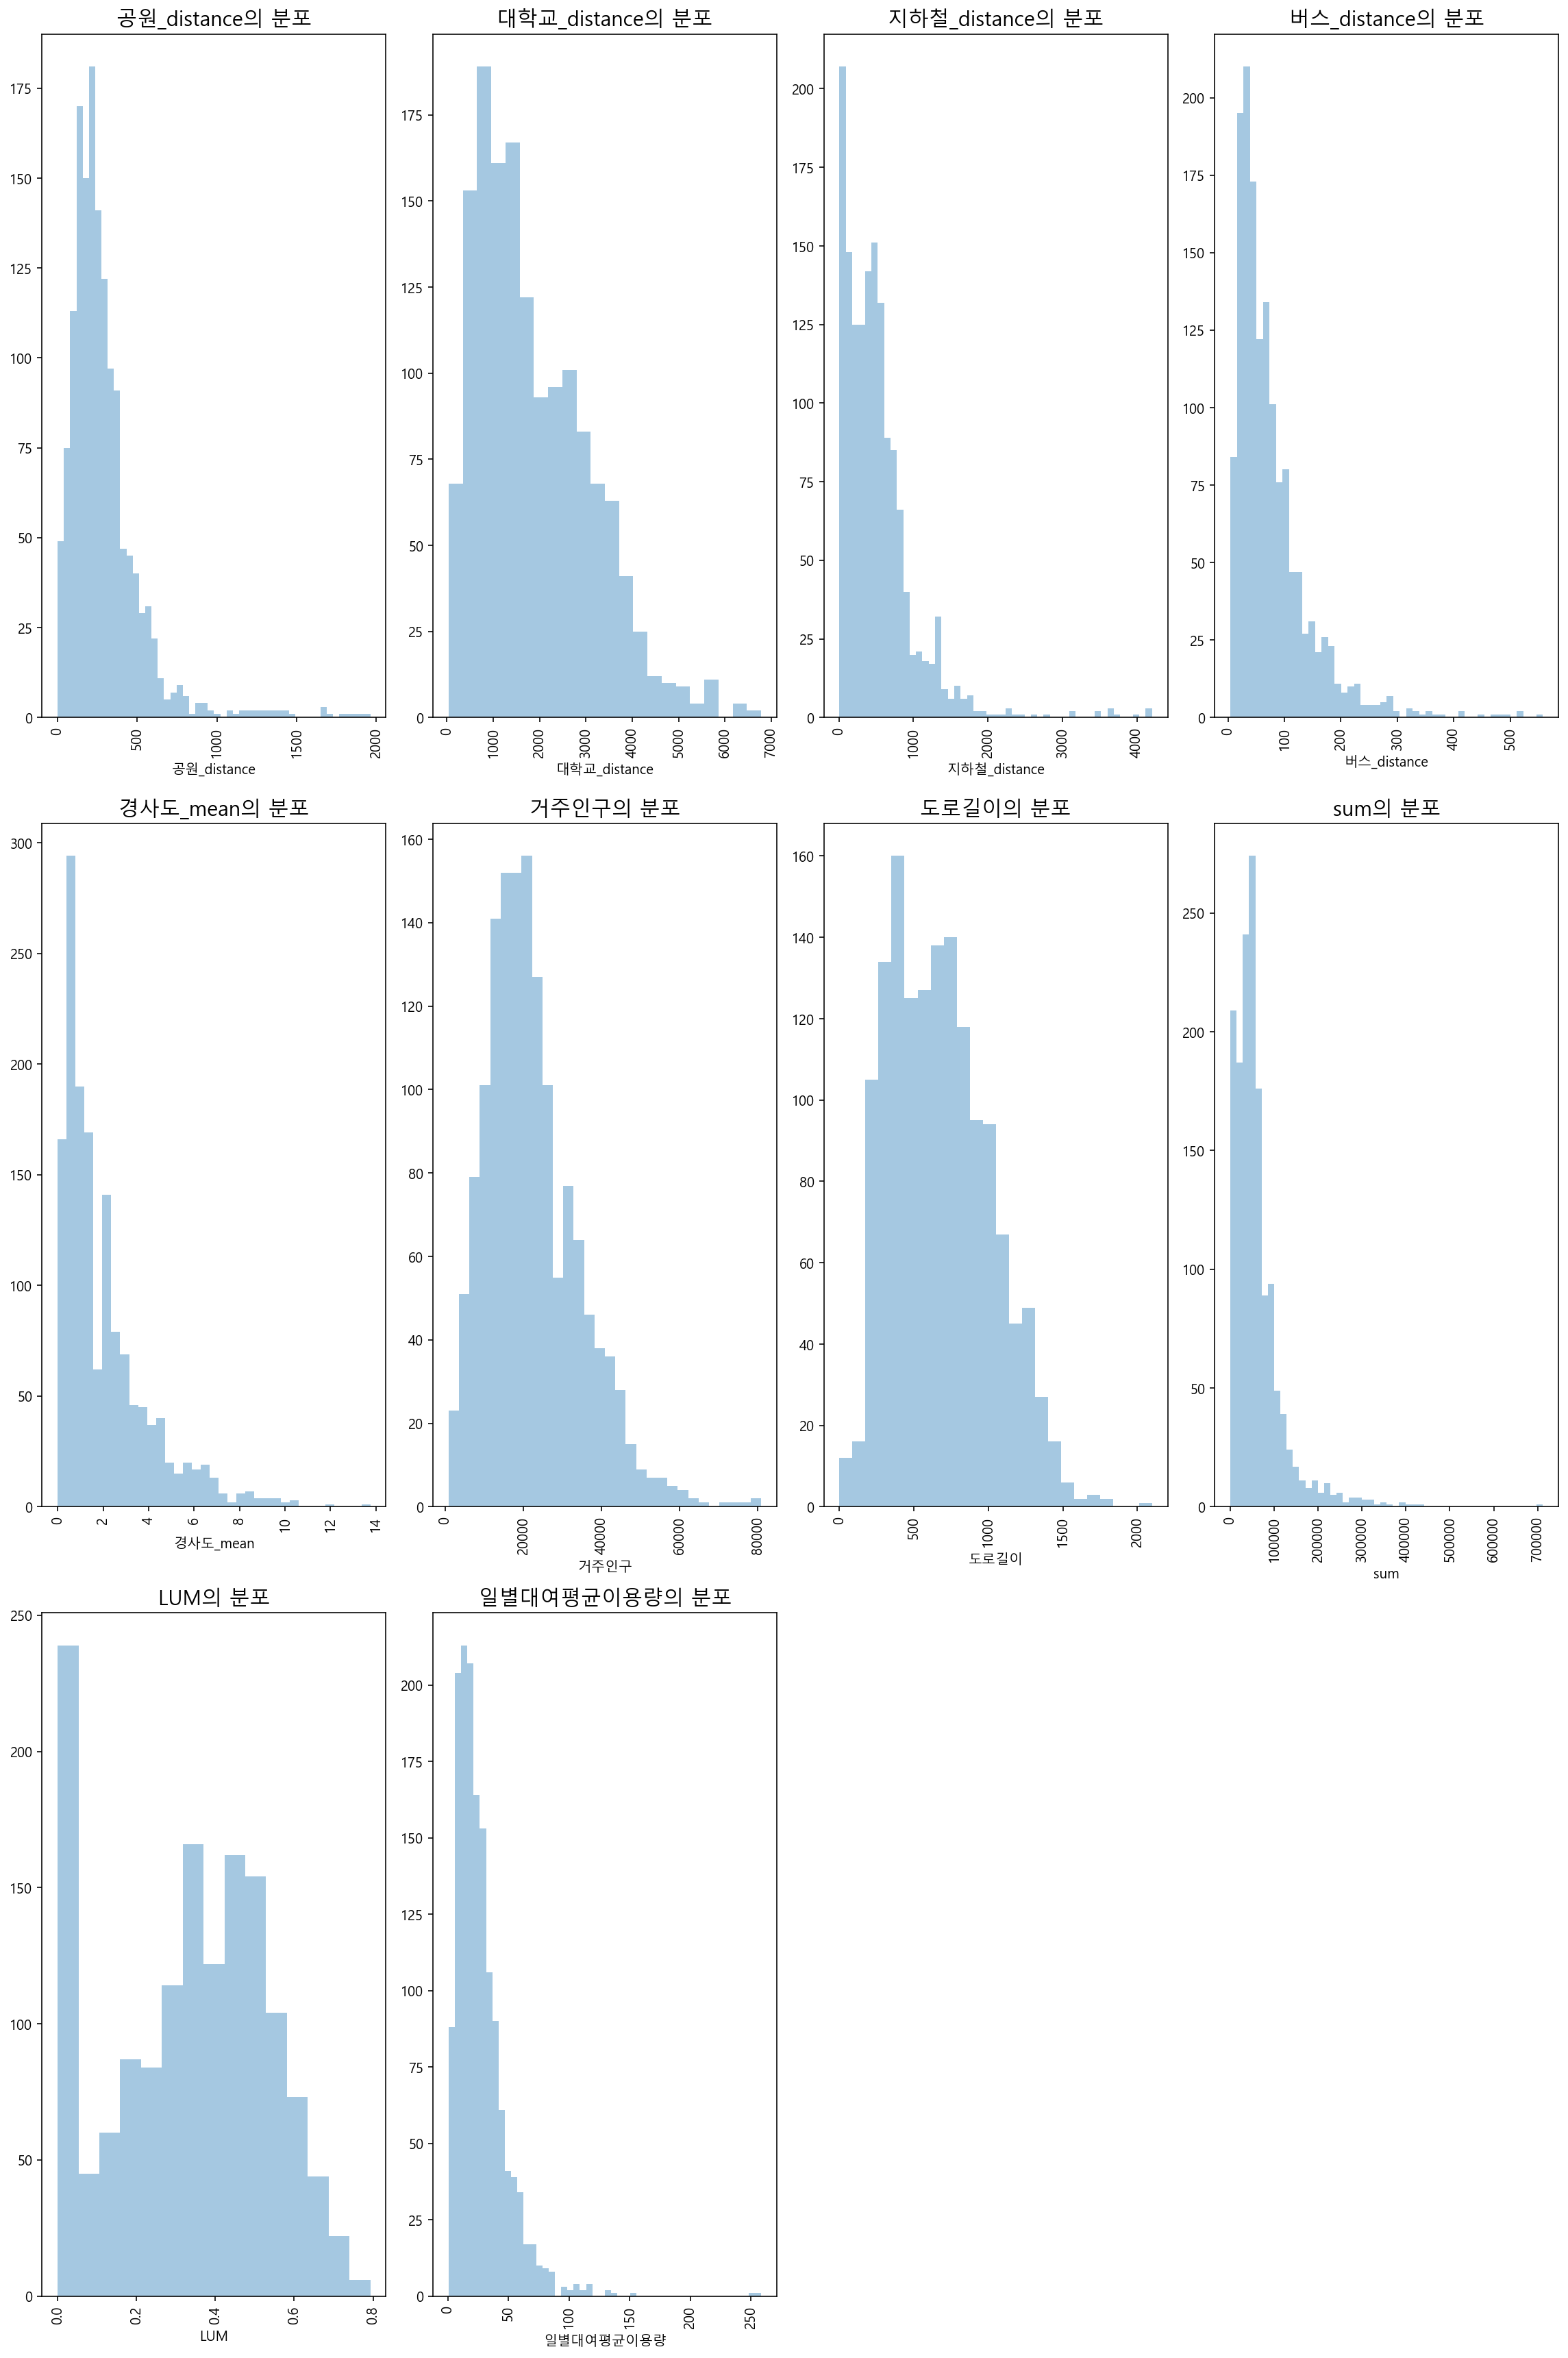

In [6]:
# 분포확인
plt.figure(figsize=(16,24)) 
n=1
for feature in total.columns:
    ax = plt.subplot(3,4,n) 
    plt.title('%s의 분포' %feature, fontsize=15)
    sns.distplot(total[feature], kde =False)
    plt.xticks(rotation=90)
    n+=1
plt.tight_layout() 
plt.show()

In [7]:
# 왜도 확인
from scipy.stats import skew

features_index = total.dtypes[total.dtypes != 'object'].index
skew_features = total[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

sum             3.084214
지하철_distance    2.959794
일별대여평균이용량       2.951318
공원_distance     2.918526
버스_distance     2.488875
경사도_mean        1.710297
dtype: float64


In [8]:
# 복사
total_log = total.copy()

In [9]:
# log변환
total_log[skew_features_top.index] = np.log1p(total[skew_features_top.index])
total_log

,공원_distance,대학교_distance,지하철_distance,버스_distance,경사도_mean,거주인구,도로길이,sum,LUM,일별대여평균이용량
대여소번호,,,,,,,,,,
502.0,4.930944,1430.131460,4.040821,4.097812,0.405465,24085,714.440640,11.838504,0.018970,5.559163
207.0,5.351727,2254.225628,4.290482,3.473748,0.693147,15710,356.416445,11.041990,0.008663,5.529168
3533.0,5.092176,639.201940,5.175335,3.781491,0.000000,43626,549.726995,11.533158,0.222047,4.914326
1210.0,5.785889,2761.514679,4.984205,4.268382,0.287682,24052,348.694407,0.000000,0.000000,4.897973
1308.0,5.809243,749.646476,6.014817,2.572870,0.810930,41364,1258.678353,11.274117,0.534877,4.772216
...,...,...,...,...,...,...,...,...,...,...
664.0,5.808780,88.481654,6.386064,5.918530,1.098612,8727,0.000000,11.144527,0.166815,2.191750
2287.0,5.236975,5396.477786,8.152100,5.610680,2.133509,8164,749.655227,9.057235,0.330571,0.509455
2391.0,5.907343,4119.802431,7.096272,4.982320,1.704748,14769,345.607938,8.148156,0.000000,0.459677


In [10]:
y_target = total_log['일별대여평균이용량']
X_features = total_log.drop('일별대여평균이용량', axis=1, inplace=False)

In [11]:
y_target_scaled = y_target.copy()
X_features_scaled = X_features.copy()

In [12]:
from sklearn.preprocessing import MinMaxScaler

#원래 값을 구하기 위해?
scaler_x = MinMaxScaler()
X_features_scaled = scaler_x.fit_transform(X_features)

scaler_y = MinMaxScaler()
y_target_scaled = scaler_y.fit_transform(y_target.values.reshape(-1,1))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, y_target_scaled, test_size=0.2, random_state=156)

## Sklearn

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평가
def evaluate_regr(y,pred):
    mse = mean_squared_error(y,pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y,pred)
    r2 = r2_score(y,pred)
    print('MSE 값: {0:.3f}, RMSE 값: {1:.3f}, MAE 값: {2:.3f}, R2 값: {3:.3f}'.format(mse,rmse,mae,r2))

# 예측
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

In [15]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression,ElasticNet

ridge = Ridge()
lasso = Lasso()
lr = LinearRegression()

for model in [lr, ridge, lasso]:
    get_model_predict(model, X_train, X_test, y_train, y_test)

### LinearRegression ###
MSE 값: 0.013, RMSE 값: 0.114, MAE 값: 0.091, R2 값: 0.384
### Ridge ###
MSE 값: 0.013, RMSE 값: 0.114, MAE 값: 0.091, R2 값: 0.383
### Lasso ###
MSE 값: 0.021, RMSE 값: 0.145, MAE 값: 0.114, R2 값: -0.001


### 파라미터 조정

In [16]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse,4),grid_model.best_params_))

In [17]:
Ridge_alp_list=[]
alp = np.arange(0,100,0.01)
for i in alp:
    Ridge_alp_list.append(round(i,2))
    
Lasso_alp_list=[]
alp = np.arange(0,1,0.01)
for i in alp:
    Lasso_alp_list.append(round(i,2))

In [18]:
ridge_params = {'alpha':Ridge_alp_list}
lasso_params = {'alpha':Lasso_alp_list}

In [19]:
print_best_params(ridge, ridge_params)

Ridge 5 CV시 최적 평균 RMSE 값:0.1165, 최적 alpha:{'alpha': 1.26}


In [20]:
print_best_params(lasso, lasso_params)

Lasso 5 CV시 최적 평균 RMSE 값:0.1165, 최적 alpha:{'alpha': 0.0}


In [21]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression,ElasticNet

ridge = Ridge(alpha=1.26)
lasso = Lasso(alpha=0)
lr = LinearRegression()

for model in [lr, ridge, lasso]:
    get_model_predict(model, X_train, X_test, y_train, y_test)

### LinearRegression ###
MSE 값: 0.013, RMSE 값: 0.114, MAE 값: 0.091, R2 값: 0.384
### Ridge ###
MSE 값: 0.013, RMSE 값: 0.114, MAE 값: 0.091, R2 값: 0.382
### Lasso ###
MSE 값: 0.013, RMSE 값: 0.114, MAE 값: 0.091, R2 값: 0.384


In [22]:
def get_top_bottom_coef(model): 
    coef = pd.Series(data = model.coef_.flatten(), index = X_features.columns )
    coef = coef.sort_values(ascending=False)
    return coef

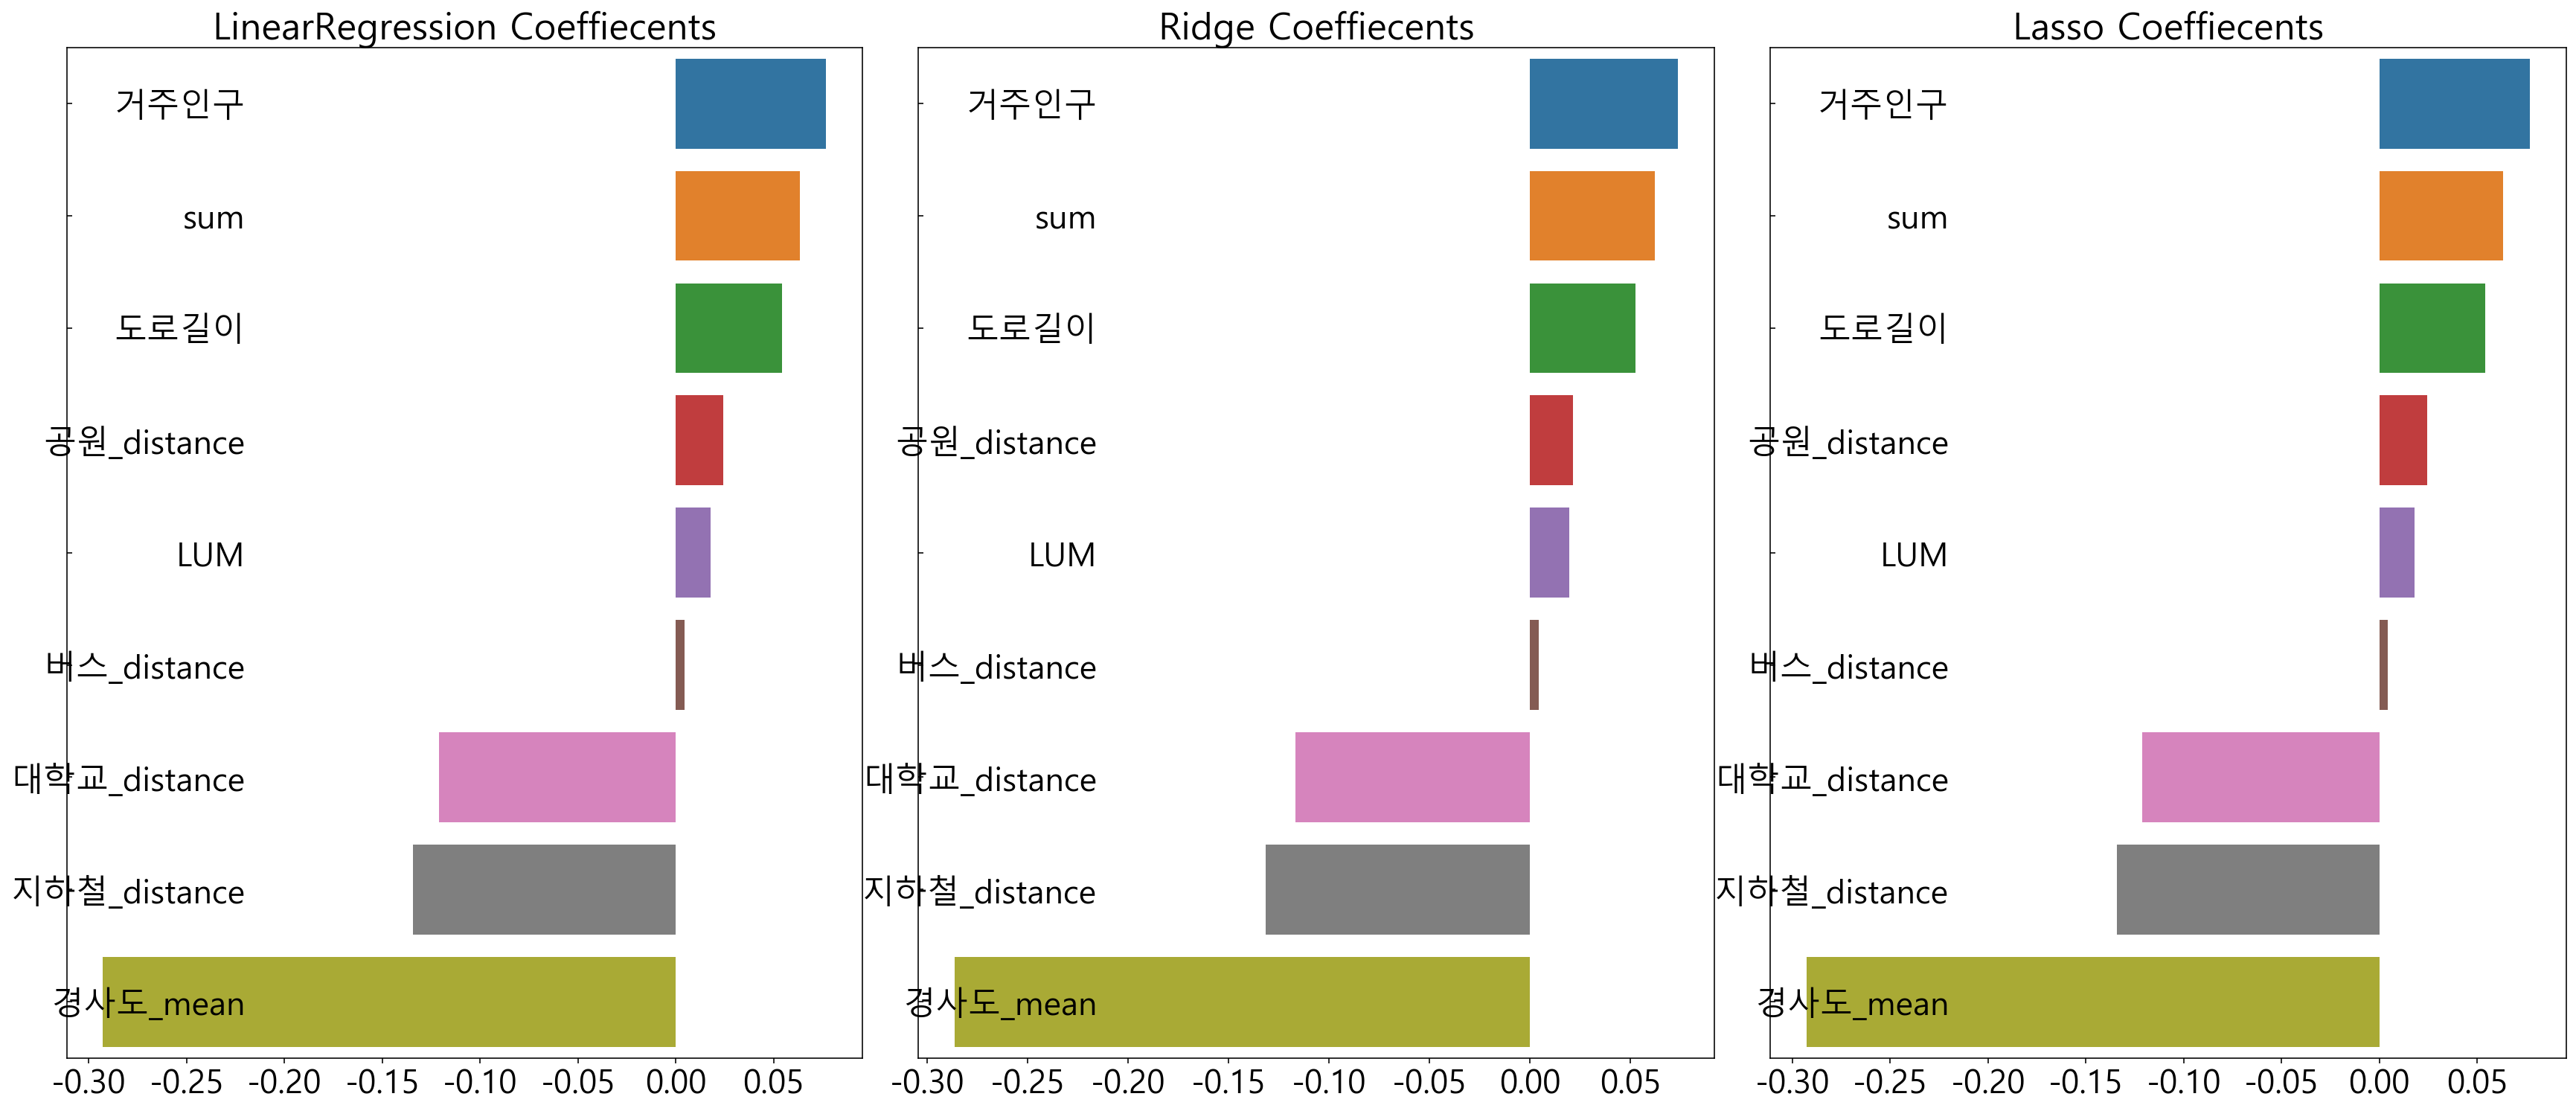

In [23]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    for i_num, model in enumerate(models): 
        coef_concat = get_top_bottom_coef(model) 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])
  

models = [lr, ridge, lasso]
visualize_coefficient(models)

In [24]:
get_top_bottom_coef(lr)

거주인구            0.076893
sum             0.063315
도로길이            0.054274
공원_distance     0.024243
LUM             0.017929
버스_distance     0.004313
대학교_distance   -0.121087
지하철_distance   -0.134302
경사도_mean       -0.292889
dtype: float64

## 예측값

In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

evaluate_regr(y_test, pred_lr)

MSE 값: 0.013, RMSE 값: 0.114, MAE 값: 0.091, R2 값: 0.384


In [26]:
y_test = scaler_y.inverse_transform(np.array(y_test).reshape(-1,1))
y_test = np.expm1(y_test)

pred_lr= scaler_y.inverse_transform(np.array(pred_lr).reshape(-1,1))
pred_lr = np.expm1(pred_lr)

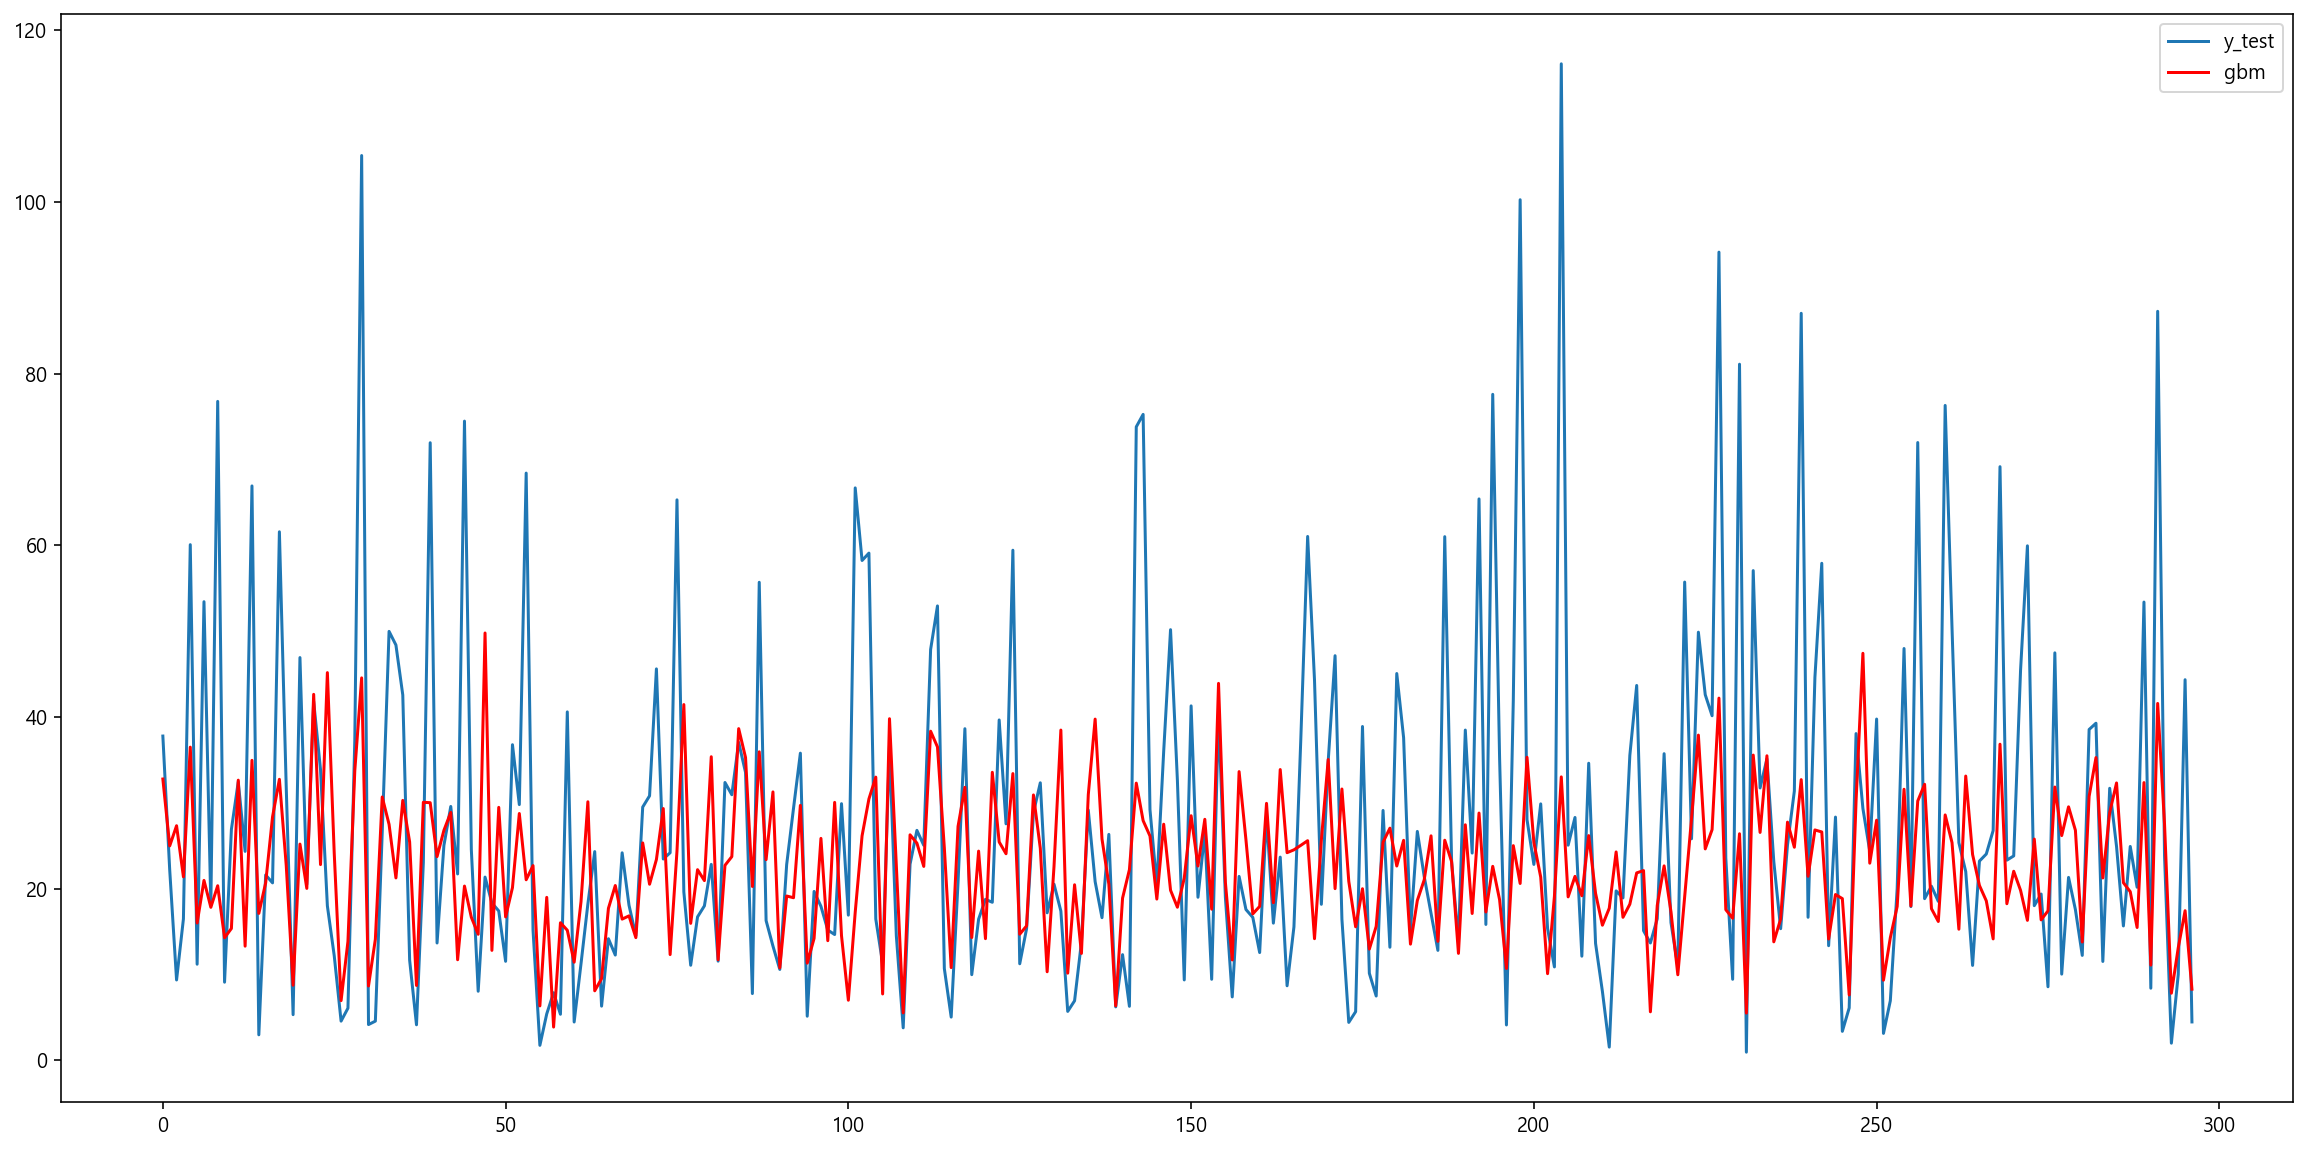

In [27]:
plt.figure(figsize=(20,10))
plt.plot(y_test, label='y_test')
plt.plot(pred_lr, 'r', label='gbm')
plt.legend()
plt.show()